## Loading data


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../data/cleaned_dataset.csv', index_col=0)
df.head()


,Female,Age,Location,Verification,Heterosexual,Homosexual,bicurious,bisexual,Dominant,Submisive,...,Member_since_month,Member_since_day,Number_of_Comments_in_public_forum,Time_spent_chating_H:M,Number_of_advertisments_posted,Number_of_offline_meetings_attended,Number of Friends,Profile_pictures,Friends_ID_list,Risk
User_ID,,,,,,,,,,,,,,,,,,,,,
10386,False,34.6,A,False,0,1,0,0,0,0,...,9,17,32,2,0,0,1,0,18260,0.0
14,False,32.2,J,False,1,0,0,0,1,0,...,11,1,710,225,9,0,7,0,"11778,32024,43768,23969,27318,45884,31277",0.0
16721,False,33.6,K,False,1,0,0,0,1,0,...,4,1,25,135,1,1,3,45,"19805,21721,19802",0.0
16957,False,34.0,H,False,1,0,0,0,1,0,...,4,8,107,21562,1,0,12,1,"40847,38183,9507,42259,5807,28118,24848,37170,...",0.0
17125,False,39.5,B,False,1,0,0,0,1,0,...,4,14,600,21,0,6,35,8,"1320,35739,34231,19097,20197,18069,12330,43342...",0.0


In [3]:
train_df = df[df['Risk'].isnull() == False]
train_df['Risk'] = train_df['Risk'].astype(int)
norisk_df = train_df[train_df['Risk'] == 0]
risk_df = train_df[train_df['Risk'] != 0]

print(train_df.shape)


(90, 29)


## Comparing low- and high-risk data points via bar charts


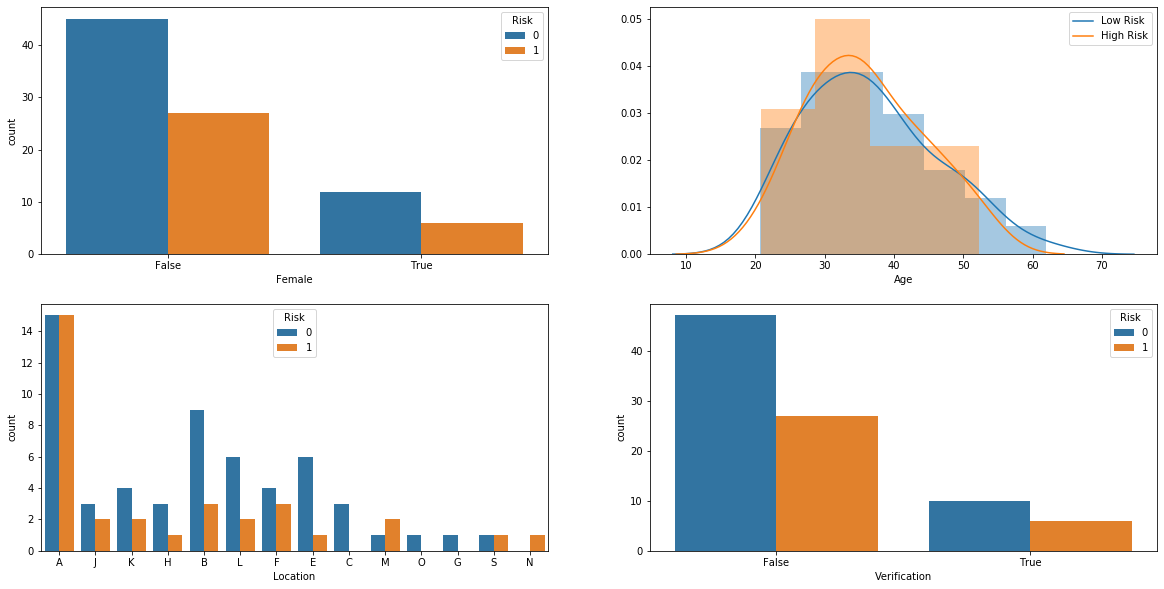

In [4]:
f, ax = plt.subplots(2, 2, figsize=(20, 10))

# Top left plot: gender.
sns.countplot(x='Female', hue='Risk', data=train_df, ax=ax[0][0])

# Top right plot: age.
sns.distplot(norisk_df['Age'], kde_kws={'label': 'Low Risk'}, ax=ax[0][1])
sns.distplot(risk_df['Age'], kde_kws={'label': 'High Risk'}, ax=ax[0][1])

# Bottom left: location.
sns.countplot(x='Location', hue='Risk', data=train_df, ax=ax[1][0])

# Bottom right: whether a person is verified.
sns.countplot(x='Verification', hue='Risk', data=train_df, ax=ax[1][1])

plt.show()


Some interpretation could be achieved from these visualizations:
- The ratio of the number of low-risk users to that of high-risk users is high,
as is the ratio of the number of males to the number of females. In other words,
there are more low-risk than high-risk users, and more male than female users.
- Most users are in their late 20s to mid 60s, no clear different age
distributions between low-risk and high-risk users.
- There are more low-risk than high-risk users in most registered locations,
expect for location M and N.
- Most users are not registered in the forum.

Possible features to explore: orientation, polarity, looking-for, etc.


## Exploring distribution of numerical attributes


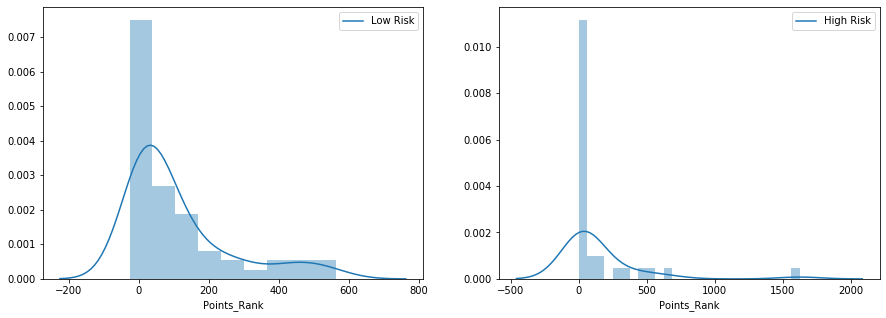

In [5]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(norisk_df['Points_Rank'], kde_kws={'label': 'Low Risk'}, ax=ax[0])
sns.distplot(risk_df['Points_Rank'], kde_kws={'label': 'High Risk'}, ax=ax[1])

plt.show()


Possible features to explore: online activity statistics, number of friends


## Feature correlation matrix


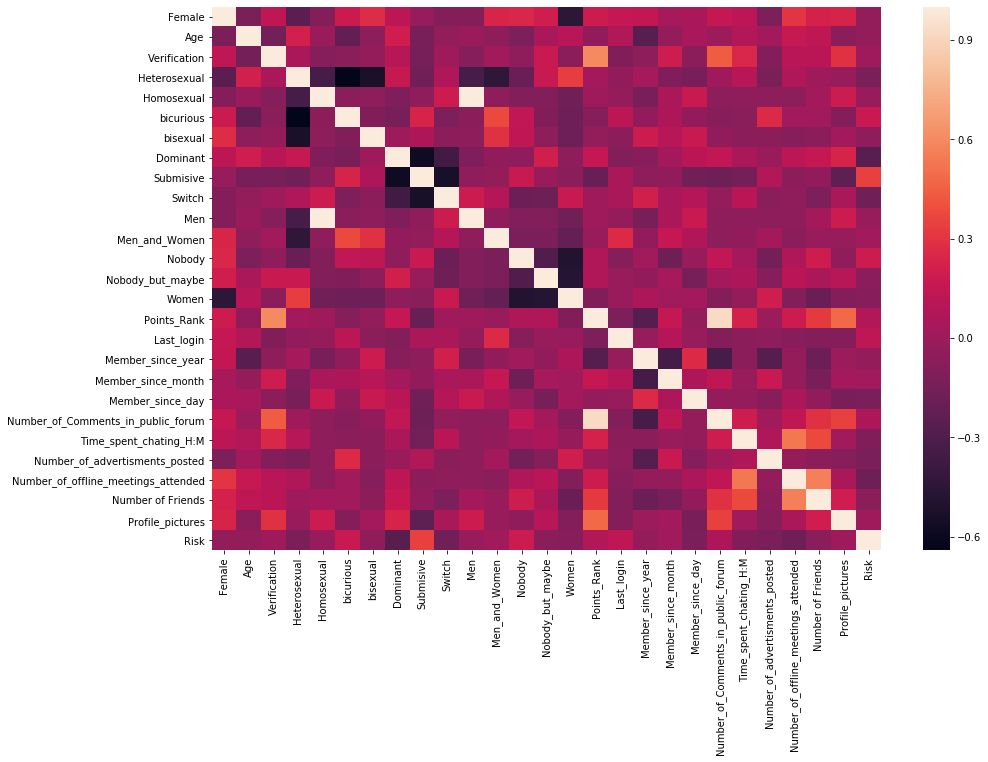

In [6]:
corr_matrix = train_df.drop(['Friends_ID_list'], axis=1).corr()

f, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.heatmap(corr_matrix)

plt.show()


## Insights from machine learning


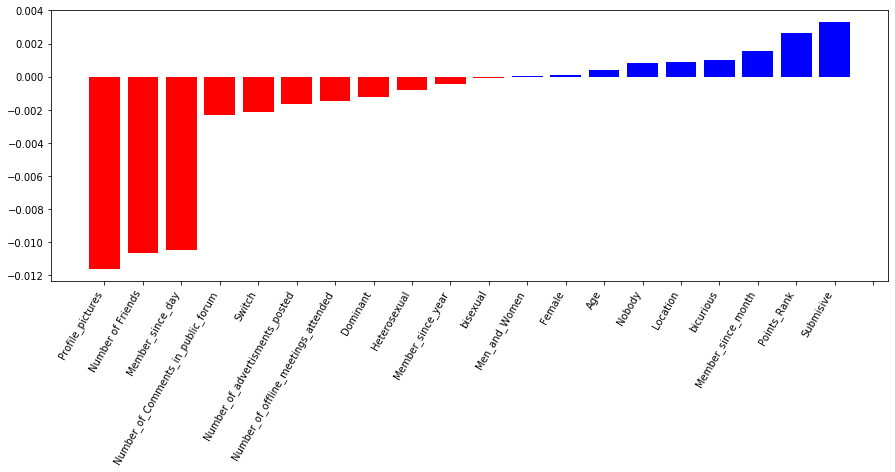

In [7]:
from sklearn.svm import LinearSVC


location_means = train_df.groupby('Location').mean()['Risk']
train_df['Location'] = train_df['Location'].map(location_means)
X_train = train_df.drop(['Friends_ID_list', 'Risk'], axis=1)
y_train = train_df['Risk']

clf = LinearSVC()
clf.fit(X_train, y_train)

nfeatures = 10

coef = clf.coef_.ravel()
top_positive_coefs = np.argsort(coef)[-nfeatures :]
top_negative_coefs = np.argsort(coef)[: nfeatures]
top_coefs = np.hstack([top_negative_coefs, top_positive_coefs])

plt.figure(figsize=(15, 5))
colors = ['red' if c < 0 else 'blue' for c in coef[top_coefs]]
plt.bar(np.arange(2 * nfeatures), coef[top_coefs], color = colors)
feature_names = np.array(X_train.columns)
plt.xticks(np.arange(0, 1 + 2 * nfeatures), feature_names[top_coefs], rotation=60, ha='right')

plt.show()


Here we see that no particular column label has a large absolute coefficient
value, so we say that no feature is significantly important to determine the
risk of a specific user. We however see that features like `Number_of_Friends`,
`Member_since_day`, `Number of Comments in public forum`, etc. features
representing online activeness all have negative coefficients, so we can guess
that online activeness may decrease the probability of a user's risk.

Other observations might include:
- The field `Female` has a near-zero coefficient - some can say gender plays no
role in determining a user's online risk.
- `Submissive`'s, though low, is the most positive coefficient.

